# From Pyro to NumPyro: Forecasting Hierarchical Models - Part I

In this notebook we provide a NumPyro implementation of the first model presented in the Pyro forecasting documentation: [Forecasting III: hierarchical models](https://pyro.ai/examples/forecasting_iii.html). This model generalizes the local level model with seasonality presented in the univariate example [Forecasting I: univariate, heavy tailed](https://pyro.ai/examples/forecasting_i.html) (see [From Pyro to NumPyro: Forecasting a univariate, heavy tailed time series](https://juanitorduz.github.io/numpyro_forecasting-univariate/) for the corresponding NumPyro implementation).

In this example, we continue working with the BART train ridership [dataset](https://www.bart.gov/about/reports/ridership).

## Prepare Notebook

In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import torch
from jax import random
from jaxtyping import Array, Float
from numpyro.contrib.control_flow import scan
from numpyro.infer import SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.infer.reparam import LocScaleReparam
from pyro.contrib.examples.bart import load_bart_od
from pyro.ops.tensor_utils import periodic_repeat

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

## Read Data

In [2]:
dataset = load_bart_od()
print(dataset.keys())
print(dataset["counts"].shape)
print(" ".join(dataset["stations"]))

dict_keys(['stations', 'start_date', 'counts'])
torch.Size([78888, 50, 50])
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


For this first model, we just model the rides to Embarcadero station, from each of the other $50$ stations.

In [3]:
data = dataset["counts"].permute(1, 2, 0).log1p()
T = data.shape[-2]
print(data.shape)

torch.Size([50, 50, 78888])


For training purposes we will use data from 90 days before the test data.

In [4]:
T2 = data.size(-1)  # end
T1 = T2 - 24 * 7 * 2  # train/test split
T0 = T1 - 24 * 90  # beginning: train on 90 days of data

In [5]:
y = jnp.array(data[..., T0:T2])
y_train = jnp.array(data[..., T0:T1])
y_test = jnp.array(data[..., T1:T2])

print(f"y: {y.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

y: (50, 50, 2496)
y_train: (50, 50, 2160)
y_test: (50, 50, 336)


In [6]:
n_stations = y_train.shape[-2]

time = jnp.array(range(T0, T2))
time_train = jnp.array(range(T0, T1))
t_max_train = time_train.size

time_test = jnp.array(range(T1, T2))
t_max_test = time_test.size

assert time_train.size + time_test.size == time.size
assert y_train.shape == (n_stations, n_stations, t_max_train)
assert y_test.shape == (n_stations, n_stations, t_max_test)

As in the example before ([From Pyro to NumPyro: Forecasting a univariate, heavy tailed time series](https://juanitorduz.github.io/numpyro_forecasting-univariate/)), we use the covariates input tensor to encode the data size. We can of course use this tensor to encode other covariates, but for this example we will not use them.

In [7]:
covariates = jnp.zeros_like(y)
covariates_train = jnp.zeros_like(y_train)
covariates_test = jnp.zeros_like(y_test)

## Repeating Seasonal Features

In the univariate case example we studied a very handy function to generate Fourier modes, [`periodic_features`](https://docs.pyro.ai/en/stable/ops.html?highlight=periodic_features#pyro.ops.tensor_utils.periodic_features). In this case, there is a very handy function to repeat the seasonal features, [`periodic_repeat`](https://docs.pyro.ai/en/stable/ops.html#pyro.ops.tensor_utils.periodic_repeat). It has two main parameters:

- `size` (int) – Desired size of the result along dimension `dim`.
- `dim` (int) – The tensor dimension along which to repeat.

Let's see some example from the docstrings.


In [8]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])

periodic_repeat(x, size=4, dim=0)

tensor([[1, 2, 3],
        [4, 5, 6],
        [1, 2, 3],
        [4, 5, 6]])

In [9]:
periodic_repeat(x, size=4, dim=1)

tensor([[1, 2, 3, 1],
        [4, 5, 6, 4]])

The translation from PyTorch to JAX is not that hard (thank you GitHub Copilot 😅).

In [10]:
def periodic_repeat_jax(tensor: Array, size: int, dim: int) -> Array:
    """
    Repeat a period-sized tensor up to given size using JAX.

    Parameters
    ----------
    tensor : Array
        A JAX array to be repeated.
    size : int
        Desired size of the result along dimension `dim`.
    dim : int
        The tensor dimension along which to repeat.

    Returns
    -------
    Array
        The repeated tensor.

    References
    ----------
    Thttps://docs.pyro.ai/en/stable/ops.html#pyro.ops.tensor_utils.periodic_repeat
    """
    assert isinstance(size, int) and size >= 0
    assert isinstance(dim, int)
    if dim >= 0:
        dim -= tensor.ndim

    period = tensor.shape[dim]
    repeats = [1] * tensor.ndim
    repeats[dim] = (size + period - 1) // period
    result = jnp.tile(tensor, repeats)

    slices = [slice(None)] * tensor.ndim
    slices[dim] = slice(None, size)

    return result[tuple(slices)]

Let's verify that the function works as expected for some examples.
assert jnp.allclose(

In [11]:
assert jnp.allclose(
    periodic_repeat_jax(jnp.array(x), 4, 0), jnp.array(periodic_repeat(x, 4, 0))
)

assert jnp.allclose(
    periodic_repeat_jax(jnp.array(x), 4, 1), jnp.array(periodic_repeat(x, 4, 1))
)

assert jnp.allclose(
    periodic_repeat_jax(jnp.array(x), 50, 1), jnp.array(periodic_repeat(x, 50, 1))
)

## Model Specification

This first hierarchical model extends the local level model with seasonality seen in the univariate case example, [From Pyro to NumPyro: Forecasting a univariate, heavy tailed time series](https://juanitorduz.github.io/numpyro_forecasting-univariate/). 

In [12]:
covariates.shape

(50, 50, 2496)

In [13]:
def model(
    covariates: Float[Array, "n_series n_series t_max"],
    y: Float[Array, "n_series n_series t_max"] | None = None,
) -> None:
    # Get the time and feature dimensions
    n_series, n_series, t_max = covariates.shape

    origin_plate = numpyro.plate("origin", n_series, dim=-3)
    destin_plate = numpyro.plate("destin", n_series, dim=-2)
    hour_of_week_plate = numpyro.plate("hour_of_week", 24 * 7, dim=-1)

    # Global scale for the drift
    drift_scale = numpyro.sample("drift_scale", dist.LogNormal(loc=-20, scale=5))

    # Sample the centered parameter for the LocScaleReparam
    destin_centered = numpyro.sample("destin_centered", dist.Uniform(low=0, high=1))

    with origin_plate, hour_of_week_plate:
        origin_seasonal = numpyro.sample("origin_seasonal", dist.Normal(loc=0, scale=5))

    with destin_plate:
        with (
            numpyro.plate("time", t_max),
            numpyro.handlers.reparam(
                config={"drift": LocScaleReparam(centered=destin_centered)}
            ),
        ):
            # Sample the drift parameters
            # We have one drift parameter per time series (station) and time point
            drift = numpyro.sample("drift", dist.Normal(loc=0, scale=drift_scale))

        with hour_of_week_plate:
            # Sample the seasonal parameters
            # We have one seasonal parameter per hour of the week and per station
            destin_seasonal = numpyro.sample(
                "destin_seasonal", dist.Normal(loc=0, scale=5)
            )

    with origin_plate, destin_plate:
        pairwise = numpyro.sample("pairwise", dist.Normal(0, 1))

    with origin_plate:
        origin_scale = numpyro.sample("origin_scale", dist.LogNormal(-5, 5))
    with destin_plate:
        destin_scale = numpyro.sample("destin_scale", dist.LogNormal(-5, 5))
        scale = origin_scale + destin_scale

    # Repeat the seasonal parameters to match the length of the time series
    seasonal = origin_seasonal + destin_seasonal
    seasonal_repeat = periodic_repeat_jax(seasonal, t_max, dim=-1)

    # Define the local level transition function
    def transition_fn(carry, t):
        "Local level transition function"
        previous_level = carry
        current_level = previous_level + drift[..., t]
        return current_level, current_level

    # Compute the latent levels using scan
    _, pred_levels = scan(
        transition_fn, init=jnp.zeros((n_series,)), xs=jnp.arange(t_max)
    )

    pred_levels = pred_levels.transpose(1, 0)

    # # Compute the mean of the model
    mu = pred_levels + seasonal_repeat + pairwise

    # Sample the observations
    with numpyro.handlers.condition(data={"obs": y}):
        numpyro.sample("obs", dist.Normal(loc=mu, scale=scale))

We can now visualize the model structure.

(50, 50, 1)
(50, 50, 1)


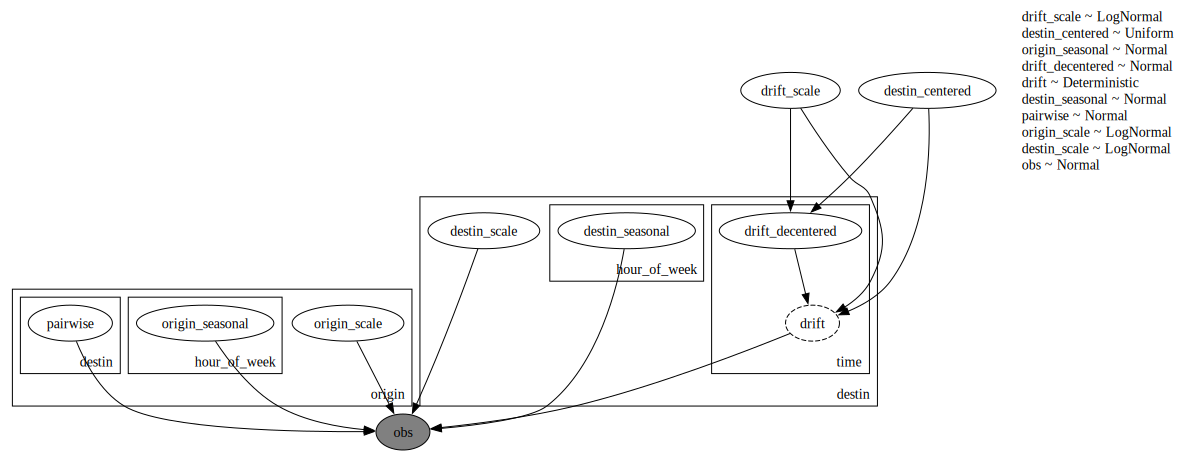

In [14]:
numpyro.render_model(
    model=model,
    model_kwargs={"covariates": covariates_train, "y": y_train},
    render_distributions=True,
    render_params=True,
)

## Prior Predictive Checks

As usual (highly recommended!), we should perform prior predictive checks.

In [15]:
# prior_predictive = Predictive(model=model, num_samples=2_000, return_sites=["obs"])

# rng_key, rng_subkey = random.split(rng_key)

# prior_samples = prior_predictive(rng_subkey, covariates_train)

# idata_prior = az.from_dict(
#     prior_predictive={k: v[None, ...] for k, v in prior_samples.items()},
#     coords={"time_train": time_train, "n_series": jnp.arange(n_stations)},
#     dims={"obs": ["time_train", "n_series"]},
# )

Let's plot the prior predictive distribution for the first $8$ stations.

In [16]:
# fig, axes = plt.subplots(
#     nrows=8, ncols=1, figsize=(15, 18), sharex=True, sharey=True, layout="constrained"
# )
# for i, ax in enumerate(axes):
#     for j, hdi_prob in enumerate([0.94, 0.5]):
#         az.plot_hdi(
#             time_train[time_train >= T1 - 3 * (24 * 7)],
#             idata_prior["prior_predictive"]["obs"].sel(n_series=i)[
#                 :, :, time_train >= T1 - 3 * (24 * 7)
#             ],
#             hdi_prob=hdi_prob,
#             color="C0",
#             fill_kwargs={
#                 "alpha": 0.3 + 0.2 * j,
#                 "label": f"{hdi_prob*100:.0f}% HDI (train)",
#             },
#             smooth=False,
#             ax=ax,
#         )
#     ax.plot(
#         time_train[time_train >= T1 - 3 * (24 * 7)],
#         data[T1 - 3 * (24 * 7) : T1, i],
#         "black",
#         lw=1,
#         label="Truth",
#     )
#     ax.axvline(T1, color="C3", linestyle="--", label="Train/test split")

#     ax.legend(
#         bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0, fontsize=12
#     )


# fig.suptitle("Prior predictive checks", fontsize=18, fontweight="bold");

Overall, the prior ranges look very reasonable.

## Inference with SVI

We now fir the model to the data using stochastic variational inference.

(50, 50, 1)
(50, 50, 1)
(50, 50, 1)


  0%|          | 0/1000 [00:00<?, ?it/s]

(50, 50, 1)


100%|██████████| 1000/1000 [00:21<00:00, 45.51it/s, init loss: 1727067648.0000, avg. loss [951-1000]: 9584779.5600]


CPU times: user 1min, sys: 10.8 s, total: 1min 11s
Wall time: 22.3 s


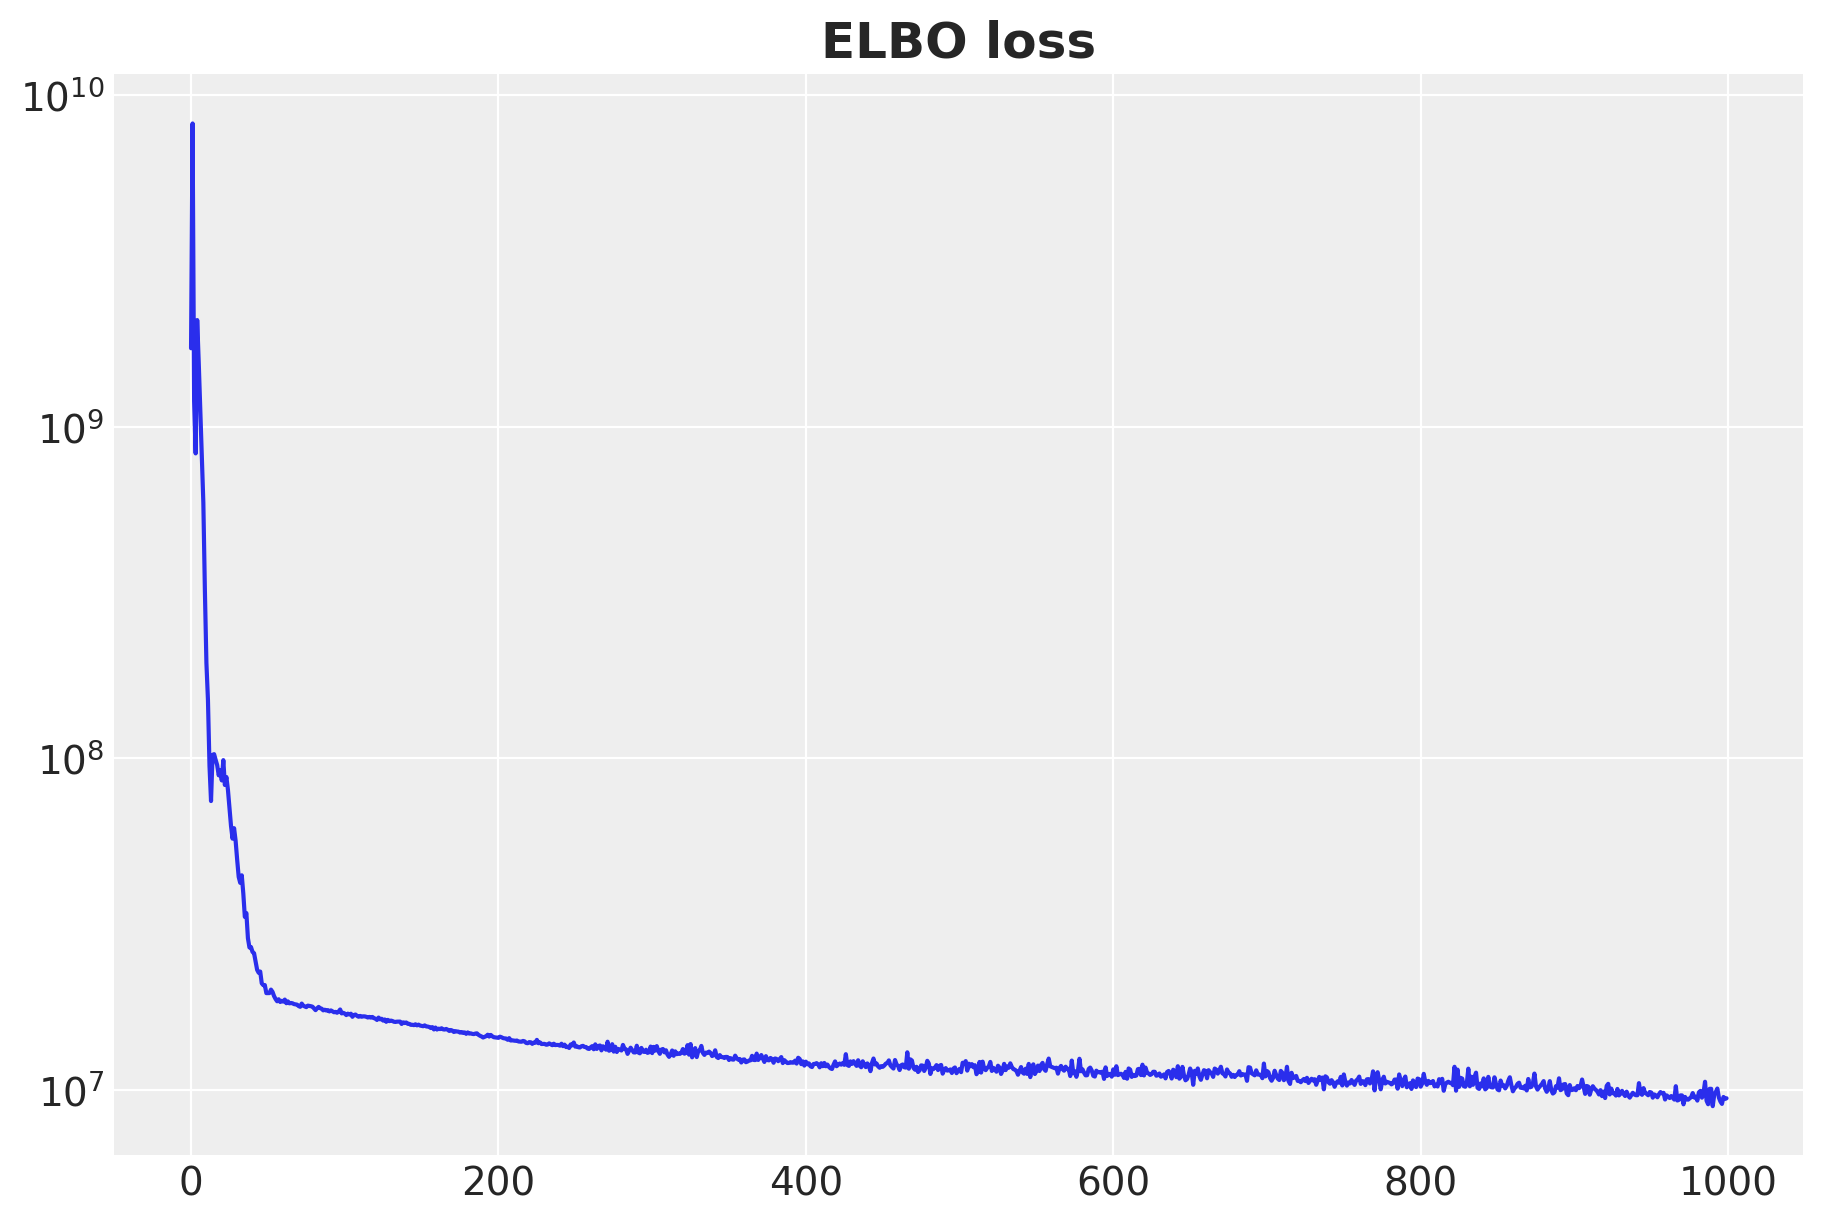

In [18]:
%%time

guide = AutoNormal(model)
optimizer = numpyro.optim.Adam(step_size=0.1)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
num_steps = 1000

rng_key, rng_subkey = random.split(key=rng_key)

svi_result = svi.run(
    rng_subkey,
    num_steps,
    covariates_train,
    y_train,
)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
ax.set_yscale("log")
ax.set_title("ELBO loss", fontsize=18, fontweight="bold");

The resulting ELBO loss good!

## Posterior Predictive Check

Next, we generate posterior predictive samples for the forecast for each of the $50$ stations.

In [19]:
posterior = Predictive(
    model=model,
    guide=guide,
    params=svi_result.params,
    num_samples=100,
    return_sites=["obs"],
)

In [29]:
rng_key, rng_subkey = random.split(rng_key)

idata_train = az.from_dict(
    posterior_predictive={
        k: v[None, ...] for k, v in posterior(rng_subkey, covariates_train).items()
    },
    coords={
        "time_train": time_train,
        "n_series_origin": jnp.arange(n_stations),
        "n_series_destin": jnp.arange(n_stations),
    },
    dims={"obs": ["n_series_origin", "n_series_destin", "time_train"]},
)

idata_test = az.from_dict(
    posterior_predictive={
        k: v[None, ...] for k, v in posterior(rng_subkey, covariates).items()
    },
    coords={
        "time": time,
        "n_series_origin": jnp.arange(n_stations),
        "n_series_destin": jnp.arange(n_stations),
    },
    dims={"obs": ["n_series_origin", "n_series_destin", "time"]},
)

(50, 50, 1)
(50, 50, 1)


As in the univariate case example, we compute the CRPS for the training and test data.

In [31]:
def crps(
    truth: Float[Array, "t_max n_series"],
    pred: Float[Array, "n_samples t_max n_series"],
    sample_weight: Float[Array, " t_max"] | None = None,
) -> Float[Array, ""]:
    if pred.shape[1:] != (1,) * (pred.ndim - truth.ndim - 1) + truth.shape:
        raise ValueError(
            f"""Expected pred to have one extra sample dim on left.
            Actual shapes: {pred.shape} versus {truth.shape}"""
        )

    absolute_error = jnp.mean(jnp.abs(pred - truth), axis=0)

    num_samples = pred.shape[0]
    if num_samples == 1:
        return jnp.average(absolute_error, weights=sample_weight)

    pred = jnp.sort(pred, axis=0)
    diff = pred[1:] - pred[:-1]
    weight = jnp.arange(1, num_samples) * jnp.arange(num_samples - 1, 0, -1)
    weight = weight.reshape(weight.shape + (1,) * (diff.ndim - 1))

    per_obs_crps = absolute_error - jnp.sum(diff * weight, axis=0) / num_samples**2
    return jnp.average(per_obs_crps, weights=sample_weight)


crps_train = crps(
    y_train,
    jnp.array(idata_train["posterior_predictive"]["obs"].sel(chain=0)),
)

crps_test = crps(
    y_test,
    jnp.array(
        idata_test["posterior_predictive"]["obs"].sel(chain=0).sel(time=slice(T1, T2))
    ),
)

TypeCheckError: Type-check error whilst checking the parameters of __main__.crps.
The problem arose whilst typechecking parameter 'truth'.
Actual value: f32[50,50,2160]
Expected type: <class 'Float[Array, 't_max n_series']'>.
----------------------
Called with parameters: {'truth': f32[50,50,2160], 'pred': f32[100,50,50,2160], 'sample_weight': None}
Parameter annotations: (truth: Float[Array, 't_max n_series'], pred: Float[Array, 'n_samples t_max n_series'], sample_weight: Float[Array, 't_max'] | None = None) -> Any.


Finally, we reproduce the model fit and plot from the Pyro example.

KeyError: "'n_series' is not a valid dimension or coordinate for Dataset with dimensions FrozenMappingWarningOnValuesAccess({'chain': 1, 'draw': 100, 'n_series_origin': 50, 'n_series_destin': 50, 'time_train': 2160})"

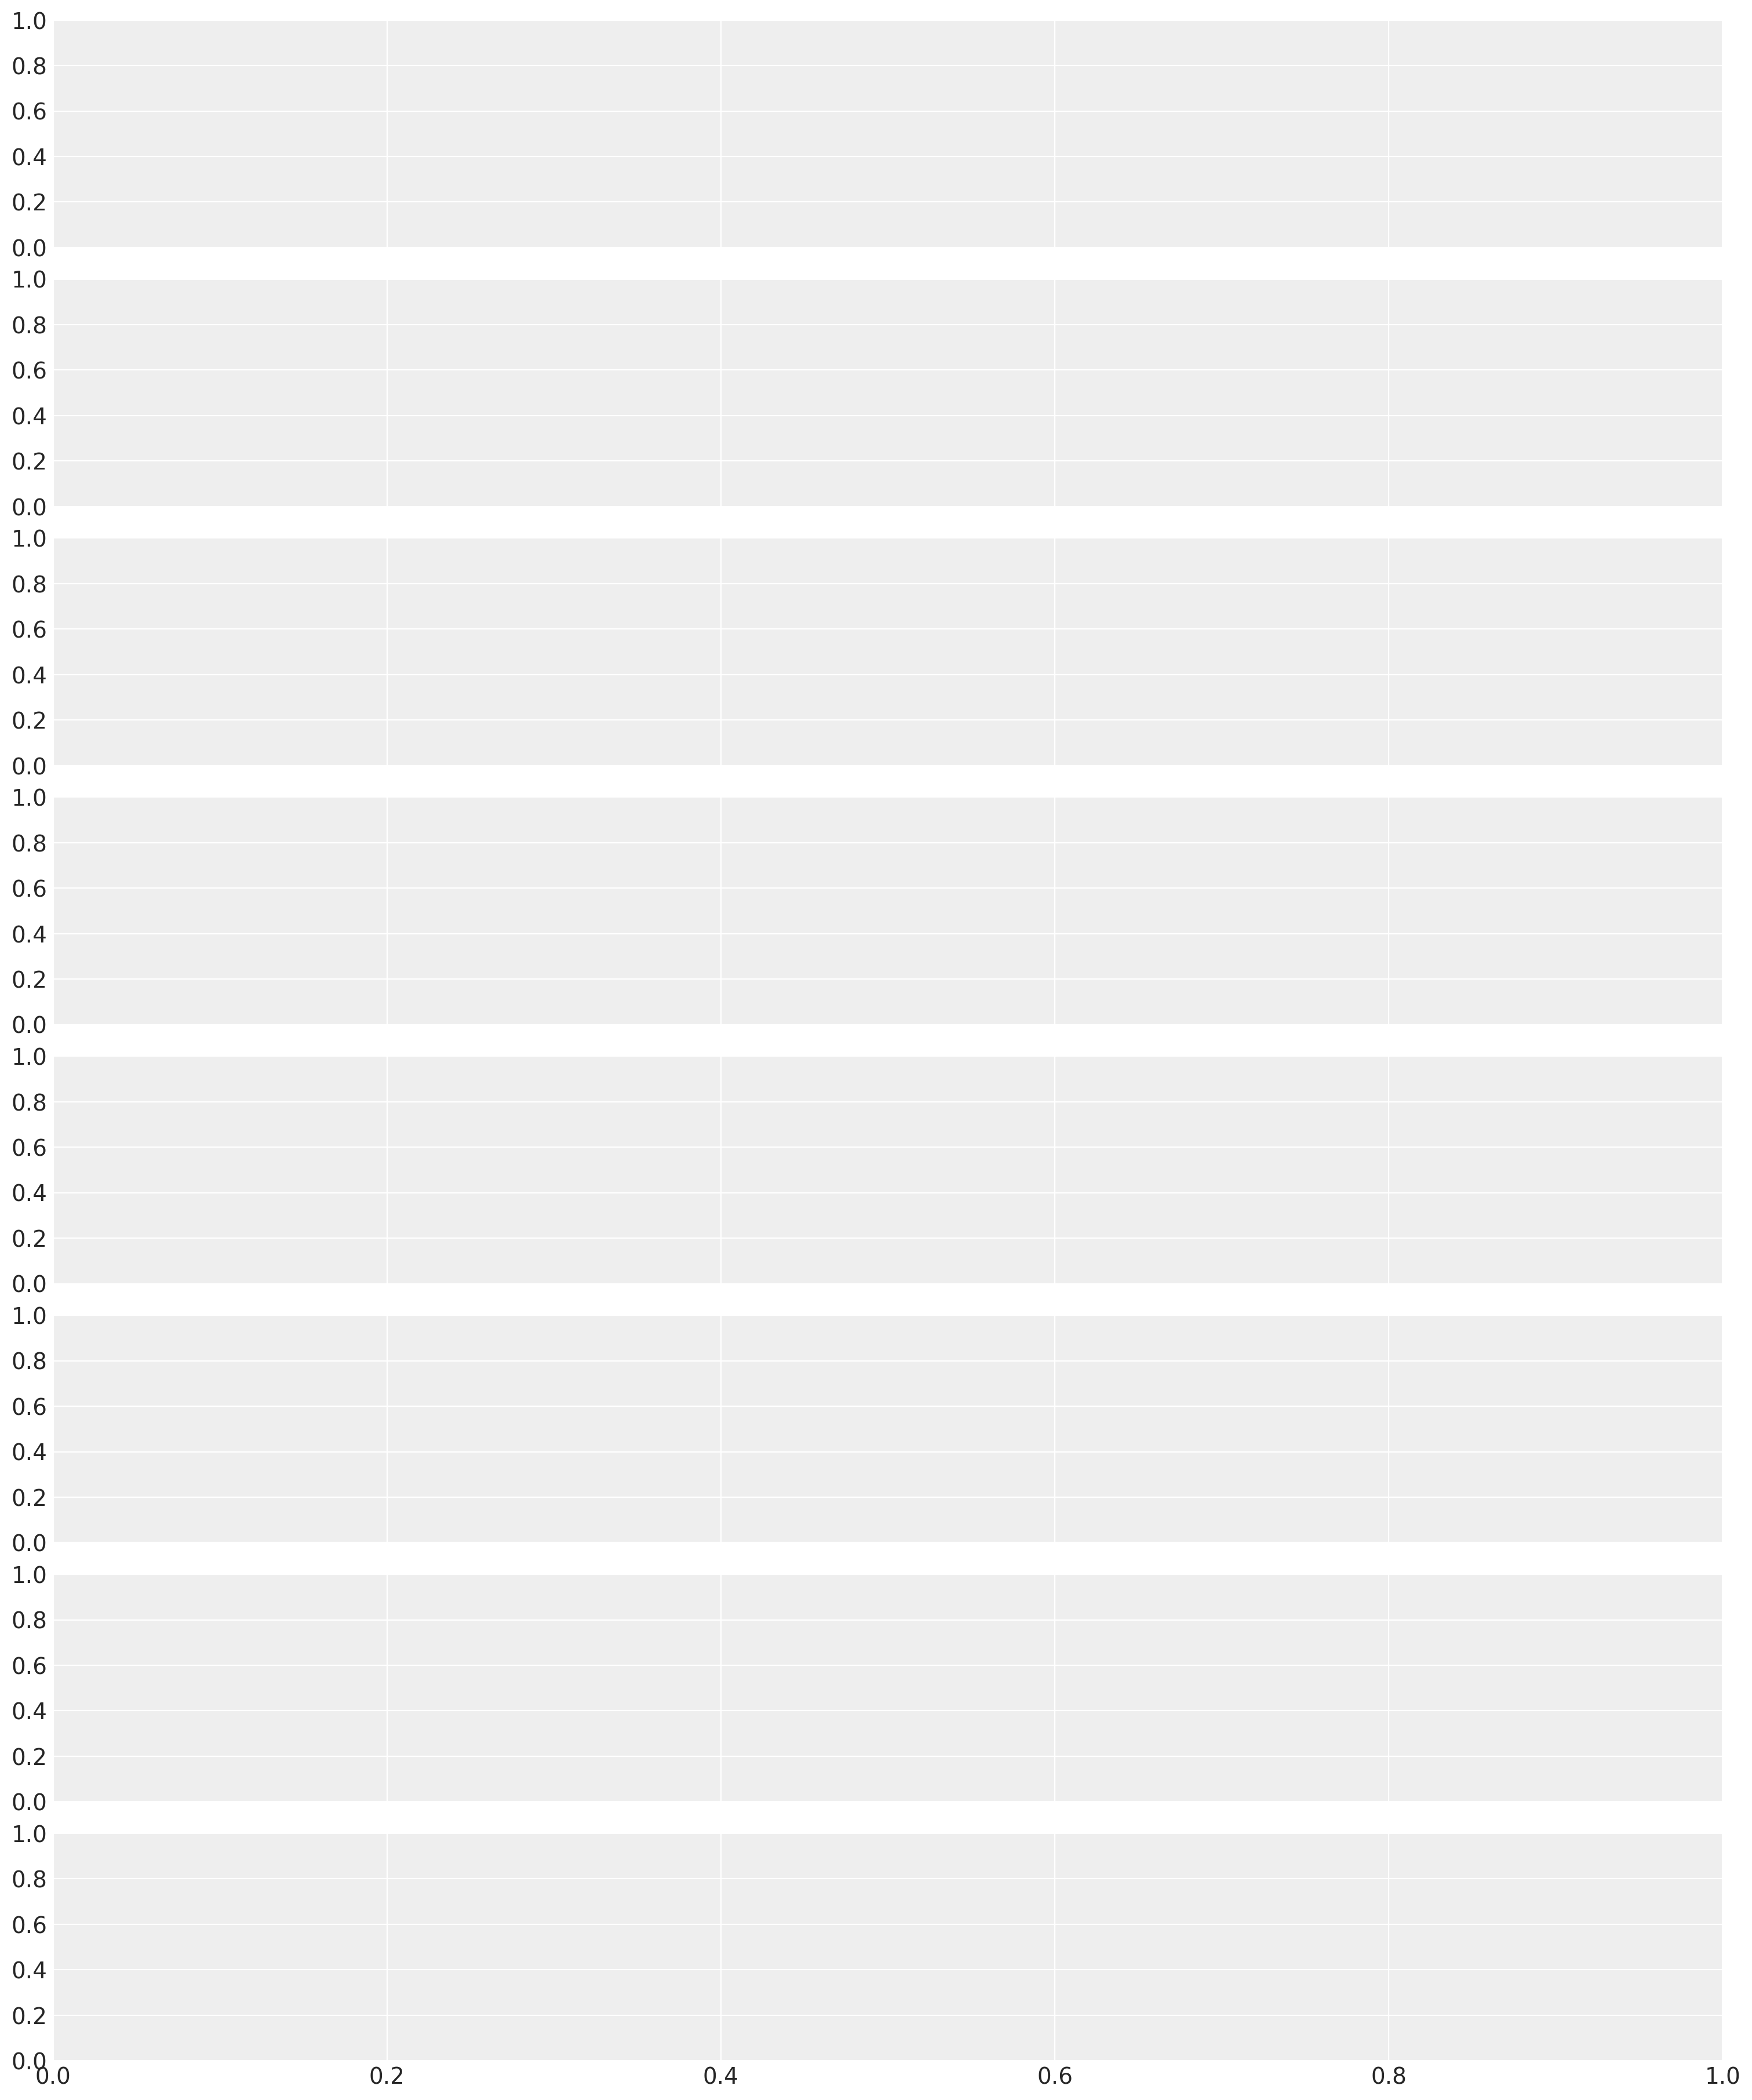

In [32]:
christmas_index = 78736

fig, axes = plt.subplots(
    nrows=8, ncols=1, figsize=(15, 18), sharex=True, sharey=True, layout="constrained"
)
for i, ax in enumerate(axes):
    for j, hdi_prob in enumerate([0.94, 0.5]):
        az.plot_hdi(
            time_train[time_train >= T1 - 24 * 7],
            idata_train["posterior_predictive"]["obs"].sel(n_series=i)[
                :, :, time_train >= T1 - 24 * 7
            ],
            hdi_prob=hdi_prob,
            color="C0",
            fill_kwargs={
                "alpha": 0.3 + 0.2 * j,
                "label": f"{hdi_prob*100:.0f}% HDI (train)",
            },
            smooth=False,
            ax=ax,
        )
        az.plot_hdi(
            time[time >= T1],
            idata_test["posterior_predictive"]["obs"].sel(n_series=i)[:, :, time >= T1],
            hdi_prob=hdi_prob,
            color="C1",
            fill_kwargs={
                "alpha": 0.2 + 0.2 * j,
                "label": f"{hdi_prob*100:.0f}% HDI (test)",
            },
            smooth=False,
            ax=ax,
        )
    ax.axvline(christmas_index, color="C2", lw=20, alpha=0.2, label="Christmas")
    ax.plot(
        time[time >= T1 - 24 * 7],
        data[T1 - 24 * 7 : T2, i],
        "black",
        lw=1,
        label="Truth",
    )
    ax.axvline(T1, color="C3", linestyle="--", label="Train/test split")

    ax.legend(
        bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0, fontsize=12
    )

ax.text(
    christmas_index,
    -3,
    "Christmas",
    color="C2",
    fontsize=10,
    fontweight="bold",
    horizontalalignment="center",
)

fig.suptitle(
    f"""Posterior predictive checks

    Train CRPS: {crps_train:.4f} | Test CRPS: {crps_test:.4f}
    """,
    fontsize=18,
    fontweight="bold",
);

Observe that, as mentioned in the Pyro example, performs quite well except for the test data around Christmas. We can solve this by enlarging the size of the training data and by adding these special holidays as features (either dummies or Gaussian bump functions, see [Seasonal Bump Functions](https://juanitorduz.github.io/bump_func/)).